#Задача
Разряд пассивной корректирующей цепи происходит по закону:
$$U=U_0e^{-t/\tau}$$

In [1]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import matplotlib
from matplotlib import pyplot as plt

##Значения измеренного напряжения на выходе цепи

In [2]:
T = np.array([x*0.1 for x in range(0,8)])
U_measured = np.array([9.53, 5.134, 2.635, 1.353, 0.695, 0.357, 0.183, 0.094])

In [3]:
table = pd.DataFrame({'T': T, 'U_изм': U_measured})
table

T  U_изм
0  0.0  9.530
1  0.1  5.134
2  0.2  2.635
3  0.3  1.353
4  0.4  0.695
5  0.5  0.357
6  0.6  0.183
7  0.7  0.094

Другой вариант оформления таблицы

In [4]:
table = PrettyTable()
table.add_column('T', T)
table.add_column('U_изм', U_measured)
table.float_format['T'] = ".1"
print(table)

+-----+-------+
|  T  | U_изм |
+-----+-------+
| 0.0 |  9.53 |
| 0.1 | 5.134 |
| 0.2 | 2.635 |
| 0.3 | 1.353 |
| 0.4 | 0.695 |
| 0.5 | 0.357 |
| 0.6 | 0.183 |
| 0.7 | 0.094 |
+-----+-------+


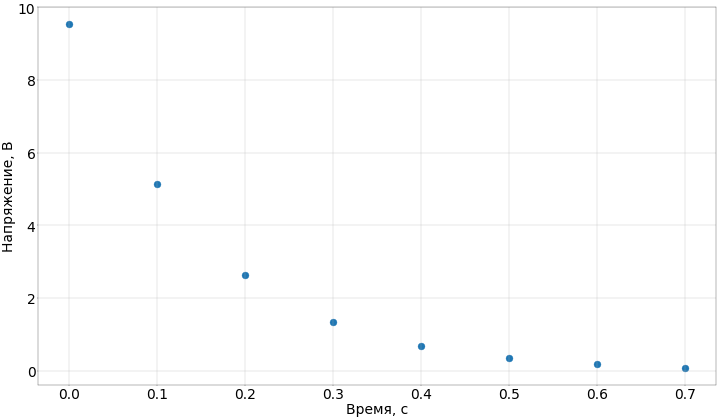

In [5]:
matplotlib.rcParams.update({'font.size': 40})
fig, ax = plt.subplots()
ax.scatter(T,U_measured, s=4e2)
plt.xticks(T)
plt.grid(True)
plt.xlabel('Время, c')
plt.ylabel('Напряжение, В')
fig.set_figwidth(35)
fig.set_figheight(20)
fig.set_dpi(25)

##Начальные приближения

In [6]:
import sympy as sp

In [7]:
U0, t, tau = sp.symbols('U0 t tau')
U = sp.Function('U')(U0,t,tau)
U = U0*sp.exp(-t/tau)
U

U0*exp(-t/tau)

Приближение для $U_0$ - измерение $U$ в нулевой момент времени

In [8]:
U0_0 = U_measured[0]

Приближение для $\tau$ - усреднение по трем измерениям

In [9]:
from sympy.solvers import solve

In [10]:
tau_0 = 0
for i in [1,4,7]:
  tau_0 += solve(U.subs([(U0,U0_0), (t,T[i])])-U_measured[i], tau)[0]
tau_0 /= 3
tau_0

0.155329512355782

In [11]:
c_init = np.array([U0_0, tau_0])

##Оценка параметров

Критерий качества
$J(\hat{\bar{c}}) = [\bar{e}(j)-\Psi(j)(\tilde{\bar{c}}-\hat{\bar{c}}(j))]^{T}R[\bar{e}(j)-\Psi(j)(\tilde{\bar{c}}-\hat{\bar{c}}(j))]$  
Оценка на j-ой итерации 
$\hat{\bar{c}}(j+1) = \hat{\bar{c}}(j)+[\Psi(j)^{T}R\Psi(j)]^{-1}\Psi(j)^{T}R\bar{e}(j)$  

где  
$$\begin{equation}\begin{split}
\bar{e}(j) &= \begin{pmatrix}
U(0)-\tilde{U}(T(0),\hat{\bar{c}}(j))\\
...\\
U(7)-\tilde{U}(T(7),\hat{\bar{c}}(j))\\
\end{pmatrix},   
\Psi &= \left.\begin{pmatrix}
\frac{\partial\hat{U}(T(0),\tilde{\bar{c}})}{\partial{\tilde{{U_0}}}}& \frac{\partial\hat{U}(T(0),\tilde{\bar{c}})}{\partial{\tilde{{\tau}}}}\\
...& ...&\\
\frac{\partial\hat{U}(T(7),\tilde{\bar{c}})}{\partial{\tilde{{U_0}}}}& \frac{\partial\hat{U}(T(7),\tilde{\bar{c}})}{\partial{\tilde{{\tau}}}}\\
\end{pmatrix}\right|_{\tilde{\bar{c}} = \hat{\bar{c}}(j)},
\tilde{\bar{c}} &= \begin{pmatrix}
\tilde{U_0}\\
\tilde{\tau}\\
\end{pmatrix}
\end{split}\end{equation}$$

Вычисление матрицы $\Psi$

In [12]:
sp.diff(U,tau)
#.subs([(t, t_i),(U0, U0_i),(tau, tau_i)])
#.evalf()

U0*t*exp(-t/tau)/tau**2

In [13]:
#@title Расчет матрицы $\Psi(j)$
def psi_row(U,t_i,c_i):
  row = np.array([
                sp.diff(U,U0).subs([(t, t_i),(U0, c_i[0]),(tau, c_i[1])]).evalf(),
                sp.diff(U,tau).subs([(t, t_i),(U0, c_i[0]),(tau, c_i[1])]).evalf() 
  ])
  return row
  
def psi_matr(U, T, c):
  psi = np.zeros((np.size(T),np.size(c)))
  for i in range(np.size(T)):
    psi[i] = psi_row(U,T[i],c)
  return psi

In [14]:
psi_matr(U, T, c_init).shape

(8, 2)

In [15]:
#@title Расчет вектора отклонений $e(j)=U(j)-\tilde{U}(j)$ измерений от модельных значений
def e_row(meas_i, U, t_i, c_i):
  e_j = meas_i - U.subs([(t, t_i),(U0, c_i[0]),(tau, c_i[1])]).evalf()
  return e_j

def e_matr(U_meas, U, T, c):
  e = np.zeros(np.size(T))
  for i in range(np.size(T)):
    e[i] = e_row(U_meas[i], U, T[i], c)
  return e

In [16]:
e_matr(U_measured,U,T,c_init).shape

(8,)

Условие остановки  - величина относительного изменения критерия качества
$$\frac{|J(j+1)-J(j)|}{|J(j+1)|}<\varepsilon$$

In [17]:
#@title Вычисление оценок нелинейным МНК
def LS(U_meas,t,c_0,U,eps):
  N = np.size(t)
  c_prev = c_0
  c_curr = np.zeros(c_prev.shape)
  iter = 0
  J_prev = 0
  accuracy = [None]
  c_all = list()
  c_all.append(c_prev)

  while True:
    psi_j = psi_matr(U, t, c_prev)
    e_j = e_matr(U_meas, U, t, c_prev)

    matr_tmp = np.matmul( np.transpose(psi_j), np.eye(N) )
    matr1 = np.linalg.inv( np.matmul( matr_tmp, psi_j ) )
    matr2 = np.matmul( matr_tmp, e_j )
    c_curr = c_prev + np.matmul(matr1, matr2)
    
    res = e_j - np.matmul( psi_j, (c_prev-c_curr) )
    J_curr = np.matmul( np.matmul( np.transpose(res), np.eye(N) ), res)
    
    c_all.append(c_curr)
    accuracy.append(np.abs(J_prev-J_curr)/np.abs(J_curr))

    if iter == 0:
      J_prev = J_curr
      c_prev = c_curr
      iter += 1
      continue
    
    
    if( (np.abs(J_prev-J_curr)/np.abs(J_curr)) < eps ):
      break

    J_prev = J_curr
    c_prev = c_curr
    iter += 1      

  return c_curr, c_all, accuracy, iter+1

In [18]:
c_est, c_all, accuracy, iterations = LS(U_measured,T,c_init,U,3e-4)
print("Оценки параметров:", c_est)
print("Всего итераций: ", iterations)
pd.DataFrame({'Оценки': c_all,'Отн. изм. крит. кач-ва': accuracy})

Оценки параметров: [9.564992630294096 0.155927575502423]
Всего итераций:  3


Оценки Отн. изм. крит. кач-ва
0               [9.53, 0.155329512355782]                   None
1  [9.564816725237767, 0.155940444195510]       1.00000000000000
2  [9.564996290641991, 0.155927332123130]      0.770911645929158
3  [9.564992630294096, 0.155927575502423]    4.83735369027536e-5

###Возьмем менее точное начальное приближение

In [19]:
c_est, c_all, accuracy, iterations = LS(U_measured,T,np.array([5, 0.7]),U,3e-7)
print("Оценки параметров:", c_est)
print("Всего итераций: ", iterations)
pd.DataFrame({'Оценки': c_all,'Отн. изм. крит. кач-ва': accuracy})

Оценки параметров: [ 6.59341667e+00 -4.92659248e+67]
Всего итераций:  9


Оценки  Отн. изм. крит. кач-ва
0                                    [5.0, 0.7]                     NaN
1       [8.120408389117792, -0.814335505952716]            1.000000e+00
2      [4.900693284837626, -1.4822584626514033]            9.685049e-01
3      [5.6918567697540485, -5.854751353928859]            4.419487e+00
4       [6.374001144769762, -73.36633113456017]            2.622556e-01
5       [6.576155901795729, -9922.453913476662]            7.132472e-02
6       [6.59328920370357, -175206313.16214758]            5.247206e-02
7  [6.5934166594481285, -5.448377497563978e+16]            5.596222e-03
8   [6.593416666666667, -5.268581150513231e+33]            4.249627e-05
9   [6.593416666666666, -4.926592480468016e+67]            2.407182e-09

###Чуть-чуть поточнее...

In [20]:
c_est, c_all, accuracy, iterations  = LS(U_measured,T,np.array([7, 0.3]),U,3e-15)
print("Оценки параметров:", c_est)
print("Всего итераций: ", iterations)
pd.DataFrame({'Оценки': c_all,'Отн. изм. крит. кач-ва': accuracy})

Оценки параметров: [9.5649927  0.15592757]
Всего итераций:  11


Оценки  Отн. изм. крит. кач-ва
0                                 [7.0, 0.3]                     NaN
1   [9.224577702475738, 0.08211618764541573]            1.000000e+00
2    [9.47607996824203, 0.14716955078114835]            9.133802e-02
3   [9.560684255461805, 0.15607046468698083]            6.404342e+01
4    [9.56503212688104, 0.15592483291770975]            3.930155e+01
5   [9.564991931655022, 0.15592762178596803]            7.539924e-03
6   [9.564992711247776, 0.15592757013583988]            2.184788e-06
7   [9.564992696813132, 0.15592757109279654]            7.489290e-10
8   [9.564992697080573, 0.15592757107506652]            2.509279e-13
9     [9.564992697075619, 0.155927571075395]            4.106486e-15
10   [9.56499269707571, 0.15592757107538893]            4.538748e-15
11   [9.56499269707571, 0.15592757107538902]            2.161308e-15

##Совместное отображение измерений и модели

###Вычисление значений для отображения непрерывной кривой

In [21]:
x = np.linspace(T[0],T[len(T)-1],num=100)
U_LSE = np.zeros(np.size(x))
for i in range(np.size(x)):
  U_LSE[i]= U.subs([(t,x[i]),(U0, c_est[0]),(tau, c_est[1])]).evalf()

###Изображение

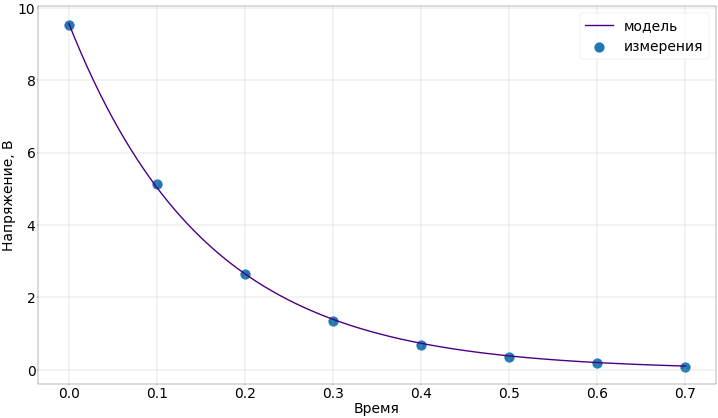

In [22]:
fig, ax = plt.subplots()
ax.scatter(T,U_measured, s=8e2, label='измерения')
plt.plot(x, U_LSE, color='indigo', linewidth='4', label='модель')
plt.xticks(T)
plt.grid(True)
plt.xlabel('Время')
plt.ylabel('Напряжение, В')
ax.legend()
fig.set_figwidth(35)
fig.set_figheight(20)
fig.set_dpi(25)

#Проверка адекватности модели

##Коэффициент детерминации

$$R^2 = \frac{D_{регрY|X}}{D_Y} =1-\frac{D_{остY}}{D_Y}$$
$R^2$ характеризует долю
разброса отклика, описываемую регрессией ($1 ≥ R^2 ≥ 0$). Чем ближе $R^2$ к единице, тем лучше описывает модель экспериментальные данные

In [25]:
U_model = c_est[0]*np.exp((-T/c_est[1]).astype(float))

R2 = 1 - (np.var(U_measured-U_model)/np.var(U_measured))
print('Коэффициент детерминации:', R2)

Коэффициент детерминации: 0.9998084071758014
